In [8]:
from osgeo import gdal
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from src.data_utils import data_processing as dp
from src.data_utils.data_processing import make_model_dataset
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import random
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import warnings
import pickle
warnings.filterwarnings("ignore")

In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

In [30]:
def metrics(model, X_test, y_test, plot_roc=False):
  # y_pred = model.predict(X_test)
  lr_probs = model.predict_proba(X_test)
  
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # calculate scores
  ns_probs = [1 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Clf: ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_probs)
  # plot the roc curve for the model
  gmeans = np.sqrt(lr_tpr * (1-lr_fpr))
  ix = np.argmax(gmeans)
  roc_auc = lr_auc
  if plot_roc:
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant 1')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Clf')
    plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
  
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  y_pred = lr_probs >= 0.5#thresholds[ix]
  acc = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(confusion_matrix(y_test, y_pred))
  metrics = [acc, precision, recall, f1, roc_auc]
  return metrics

In [11]:
def dss(start_date, end_date, station_name, station_list, ds_for_y, delta_in_x, cmip, include_day_ohe=False, speed_th=20):
    '''
    Includes several days into X. Makes dataset consisting of X from make_model_dataset(weatherstation_list.csv) and y from data_meteo_kk.csv.
    
    station_list - weatherstation_list.csv,
    ds_for_y - data_meteo_kk.csv,
    delta_in_x - number of days into X.
    '''
    a = make_model_dataset(station_name = station_name, start_date = start_date, end_date = end_date, wind_cmip=cmip, station_list = station_list)
    a.insert(loc=0, column='day', value=a.index)
    a['day'] = a['day'].dt.dayofyear

    if include_day_ohe:
        enc = OneHotEncoder()
        enc.fit(np.array(a.day).reshape(-1, 1))
        a.drop('day', axis=1, inplace=True)
        lis = [
            [
                np.concatenate(
                    (
                        np.array(a.iloc[i-delta_in_x : i]).reshape(1, -1),
                        enc.transform(
                            np.atleast_2d(a.iloc[i-1].name.dayofyear)
                        ).toarray(),
                    ),
                    axis=1,
                )
            ]
            for i in range(delta_in_x, a.shape[0])
        ]
    else:
        a.drop('day', axis=1, inplace=True)
        lis = [
            [
                np.concatenate(
                    (
                        np.array(a.iloc[i-delta_in_x : i]).reshape(1, -1),
                    ),
                    axis=1,
                )
            ]
            for i in range(delta_in_x, a.shape[0])
        ]
    
    X = np.array(lis).reshape(np.array(lis).shape[0], -1)

    ds_for_y['Дата'] = pd.to_datetime((ds_for_y['Дата']), format="%Y/%m/%d")
    ds_for_y = ds_for_y.loc[(ds_for_y['Дата'] >= pd.to_datetime(start_date)) & (ds_for_y['Дата'] <= pd.to_datetime(end_date))]
    ds_for_y = ds_for_y.loc[ds_for_y['Название метеостанции'] == station_name]
    ds_for_y = ds_for_y.groupby(ds_for_y['Дата']).max()   # Как группируется?
    max_speed = ds_for_y[['Максимальная скорость', 'Средняя скорость ветра']].max(axis=1)
    y = np.array((max_speed >= speed_th).astype(int))
    y = y[delta_in_x:a.shape[0]]

    return X, y

In [12]:
def make_ds(start_date, end_date, station_name, station_list, ds_for_y, cmip, include_day_ohe=False, speed_th=20):
    '''
    Makes dataset consisting of X from make_model_dataset(weatherstation_list.csv) and y from data_meteo_kk.csv.
    
    station_list - weatherstation_list.csv,
    ds_for_y - data_meteo_kk.csv.
    '''
    a = make_model_dataset(station_name = station_name, start_date = start_date, wind_cmip=cmip, end_date = end_date, station_list = station_list)
    a.insert(loc=0, column='day', value=a.index)
    a['day'] = a['day'].dt.dayofyear
    
    if include_day_ohe:
        enc = OneHotEncoder()
        enc.fit(np.array(a.day).reshape(-1, 1))
        a.drop('day', axis=1, inplace=True)
        lis = [[enc.transform(np.atleast_2d(a.iloc[i].name.dayofyear)).toarray()] for i in range(a.shape[0])]
        ohe_day = pd.DataFrame(np.array(lis).reshape(np.array(lis).shape[0], -1))
        X = pd.concat([a, ohe_day.set_index(a.index)], axis=1)
    else:
        a.drop('day', axis=1, inplace=True)
        X = a
    

    # X = pd.concat([a, ohe_day.set_index(a.index)], axis=1)
    

    ds_for_y['Дата'] = pd.to_datetime((ds_for_y['Дата']), format="%Y/%m/%d")
    ds_for_y = ds_for_y.loc[(ds_for_y['Дата'] >= pd.to_datetime(start_date)) & (ds_for_y['Дата'] <= pd.to_datetime(end_date))]
    ds_for_y = ds_for_y.loc[ds_for_y['Название метеостанции'] == station_name]
    ds_for_y = ds_for_y.groupby(ds_for_y['Дата']).max()   # Как группируется?
    max_speed = ds_for_y[['Максимальная скорость', 'Средняя скорость ветра']].max(axis=1)
    y = np.array((max_speed >= speed_th).astype(int))

    return X, y

In [13]:
start = '2006-01-01'
end = '2020-01-01'
df = pd.read_csv('data_meteo_kk.csv')
st = pd.read_csv('weatherstation_list.csv')
loaded_arr = np.loadtxt("wind_in_box.txt")  
# This loadedArr is a 2D array, therefore, we need to convert it to the original array shape.reshaping to get original matrice with original shape.
cmip = loaded_arr.reshape(3652, 15, 22)

In [22]:
include_day_ohe = False
single_day = True
speed_th = 20
if single_day:
    X_an, y_an = make_ds(start, end, 'Анапа', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #310
    X_ar, y_ar = make_ds(start, end, 'Армавир', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #75
    X_kr, y_kr = make_ds(start, end, 'Краснодар, Круглик', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #38
    X_so, y_so = make_ds(start, end, 'Сочи', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #28
    X_tu, y_tu = make_ds(start, end, 'Туапсе', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #160
    X_pr, y_pr = make_ds(start, end, 'Приморско-Ахтарск', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #163
    X_kp, y_kp = make_ds(start, end, 'Красная Поляна', st, df, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) 
else:
    # X_an_d, y_an_d = dss(start, end, 'Анапа', st, df, 15, include_day_ohe=include_day_ohe) #310

    X_an, y_an = dss(start, end, 'Анапа', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #310
    X_ar, y_ar = dss(start, end, 'Армавир', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #75
    X_kr, y_kr = dss(start, end, 'Краснодар, Круглик', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #38
    X_so, y_so = dss(start, end, 'Сочи', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #28
    X_tu, y_tu = dss(start, end, 'Туапсе', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #160
    X_pr, y_pr = dss(start, end, 'Приморско-Ахтарск', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) #163
    X_kp, y_kp = dss(start, end, 'Красная Поляна', st, df, 15, cmip=cmip, include_day_ohe=include_day_ohe, speed_th=speed_th) 

In [25]:
dataset_stations = [(X_an, y_an), (X_ar, y_ar), (X_kr, y_kr), (X_so, y_so), (X_tu, y_tu), (X_pr, y_pr), (X_kp, y_kp)]
dataset_stations = [s for s in dataset_stations if len(s[0]) == len(s[1])]

In [27]:
def train_test_splitter(list_to_split, split_ratio=0.4):
    random.shuffle(list_to_split)
    elements = len(list_to_split)
    middle = int(elements * split_ratio)
    return [list_to_split[:middle], list_to_split[middle:]]

def get_split_train_test(dataset_stations, split_ratio=0.4):
    splitted_test, splitted_train = train_test_splitter(dataset_stations, split_ratio=split_ratio)
    try:
        X_train = pd.concat([v[0] for v in splitted_train], axis=0)
    except TypeError:
        X_train = np.concatenate([v[0] for v in splitted_train], axis=0)
    y_train = np.concatenate([v[1] for v in splitted_train])

    try:
        X_test = pd.concat([v[0] for v in splitted_test], axis=0)
    except TypeError:
        X_test = np.concatenate([v[0] for v in splitted_test], axis=0)
    y_test = np.concatenate([v[1] for v in splitted_test])

    return X_train, y_train, X_test, y_test

def train_test_clf(clf, dataset_stations, split_ratio=0.4):
    X_train, y_train, X_test, y_test = get_split_train_test(dataset_stations, split_ratio)
    # try:
    #     print("incrementing")
        
    #     clf.fit(X_train, y_train, xgb_model=clf.get_booster())
    # except:
        
    clf.fit(X_train, y_train)
    train_metrics = metrics(clf, X_train, y_train)
    test_metrics = metrics(clf, X_test, y_test)
    print('On train:', train_metrics)
    print('On test:', test_metrics)
    return clf, test_metrics

In [37]:
clf = xgb.XGBClassifier(n_jobs=-1, eta=1e-2, scale_pos_weight = 1 / np.mean(dataset_stations[1][1]), max_depth=8)

In [38]:
clf, test_metrics = train_test_clf(clf, dataset_stations, split_ratio=0.4)

No Skill: ROC AUC=0.500
Clf: ROC AUC=0.996
[[20029    38]
 [   89   300]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.684
[[9781   62]
 [ 381    4]]
On train: [0.993791552600704, 0.8875739644970414, 0.7712082262210797, 0.8253094910591471, 0.9959177885190011]
On test: [0.9566875244427063, 0.06060606060606061, 0.01038961038961039, 0.017738359201773836, 0.6837912367019348]


No Skill: ROC AUC=0.500
Clf: ROC AUC=0.995


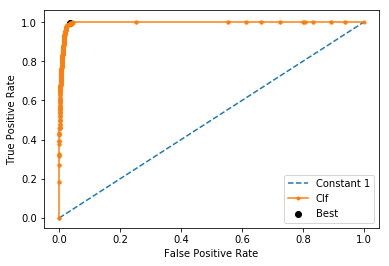

Best Threshold=0.724342, G-Mean=0.980
[[17402  2411]
 [    0   583]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.585


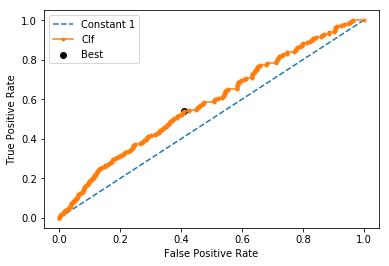

Best Threshold=0.152872, G-Mean=0.564
[[9110  897]
 [ 159   32]]
On train: [0.881790547166111, 0.19472277889111556, 1.0, 0.3259714844842046, 0.9954431568094791]
On test: [0.8964502843694843, 0.03444564047362755, 0.16753926701570682, 0.057142857142857134, 0.5849230146227484]
No Skill: ROC AUC=0.500
Clf: ROC AUC=1.000


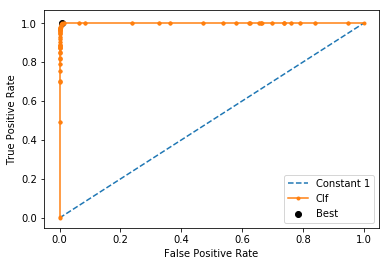

Best Threshold=0.681387, G-Mean=0.996
[[18794  1213]
 [    0   389]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.683


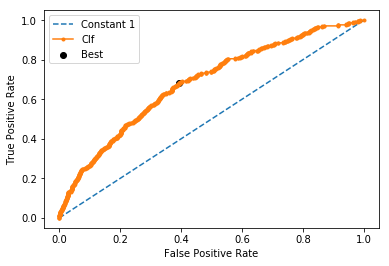

Best Threshold=0.198499, G-Mean=0.644
[[8938  875]
 [ 288   97]]
On train: [0.9405275544224357, 0.24282147315855182, 1.0, 0.3907584128578604, 0.9996980491275355]
On test: [0.885958030986468, 0.09979423868312758, 0.2519480519480519, 0.14296241709653648, 0.6833020337453232]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.990


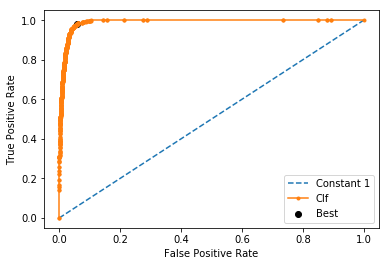

Best Threshold=0.743497, G-Mean=0.962
[[15620  4068]
 [    0   708]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.688


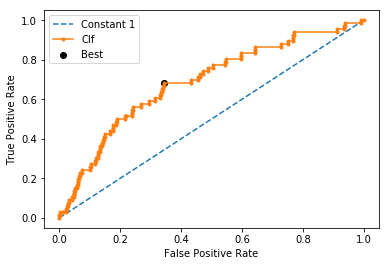

Best Threshold=0.359106, G-Mean=0.668
[[7943 2189]
 [  33   33]]
On train: [0.8005491272798588, 0.14824120603015076, 1.0, 0.25820568927789933, 0.9898945441543444]
On test: [0.7821141400274564, 0.01485148514851485, 0.5, 0.028846153846153844, 0.6883336922322314]
No Skill: ROC AUC=0.500
Clf: ROC AUC=1.000


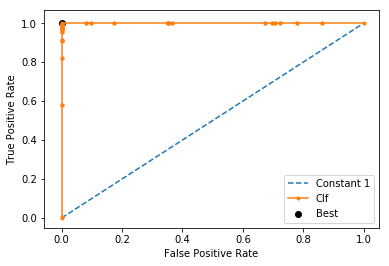

Best Threshold=0.690810, G-Mean=0.999
[[19650   442]
 [    0   304]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.598


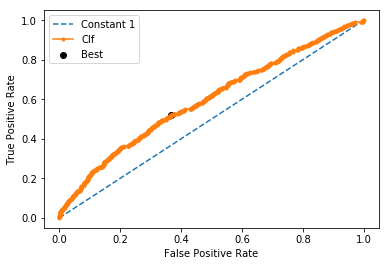

Best Threshold=0.141772, G-Mean=0.574
[[9430  298]
 [ 430   40]]
On train: [0.978329084134144, 0.4075067024128686, 1.0, 0.579047619047619, 0.9999368038601382]
On test: [0.9286134536183566, 0.11834319526627218, 0.0851063829787234, 0.09900990099009899, 0.5976783402155654]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.995


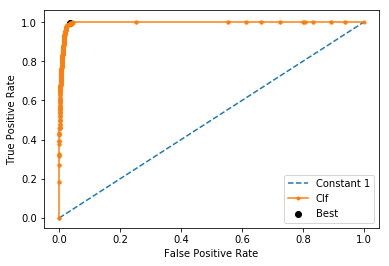

Best Threshold=0.724342, G-Mean=0.980
[[17402  2411]
 [    0   583]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.585


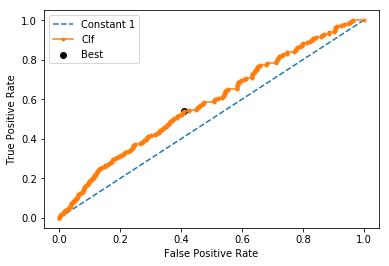

Best Threshold=0.152872, G-Mean=0.564
[[9110  897]
 [ 159   32]]
On train: [0.881790547166111, 0.19472277889111556, 1.0, 0.3259714844842046, 0.9954431568094791]
On test: [0.8964502843694843, 0.03444564047362755, 0.16753926701570682, 0.057142857142857134, 0.5849230146227484]
No Skill: ROC AUC=0.500
Clf: ROC AUC=1.000


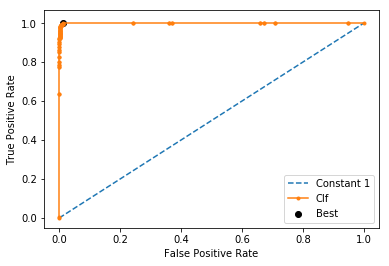

Best Threshold=0.693099, G-Mean=0.994
[[18489  1481]
 [    0   426]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.653


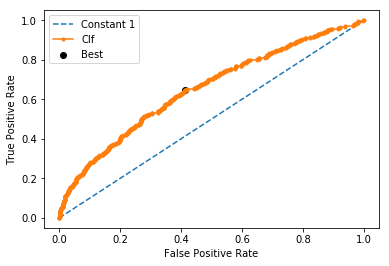

Best Threshold=0.190406, G-Mean=0.617
[[8888  962]
 [ 254   94]]
On train: [0.9273877230829575, 0.22338751966439432, 1.0, 0.36519502786112296, 0.999717651594763]
On test: [0.8807609335163757, 0.08901515151515152, 0.27011494252873564, 0.1339031339031339, 0.6525237761829745]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.997


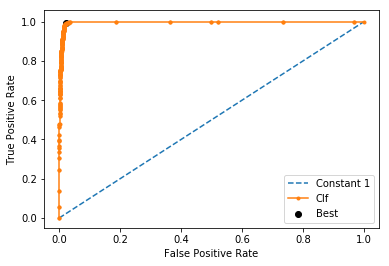

Best Threshold=0.757741, G-Mean=0.986
[[17590  2233]
 [    0   573]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.597


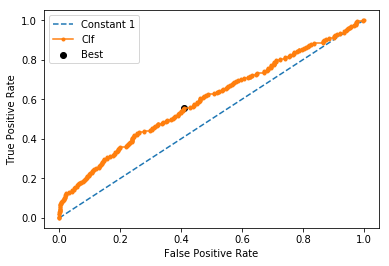

Best Threshold=0.153584, G-Mean=0.573
[[9234  763]
 [ 164   37]]
On train: [0.8905177485781526, 0.20420527441197434, 1.0, 0.3391535957383841, 0.9970159119375759]
On test: [0.9090998234948029, 0.04625, 0.18407960199004975, 0.07392607392607392, 0.5968412414271546]
No Skill: ROC AUC=0.500
Clf: ROC AUC=1.000


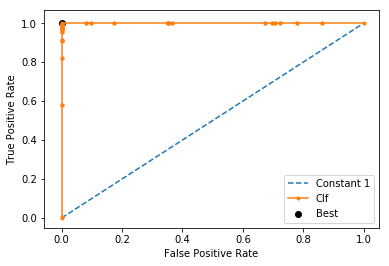

Best Threshold=0.690810, G-Mean=0.999
[[19650   442]
 [    0   304]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.598


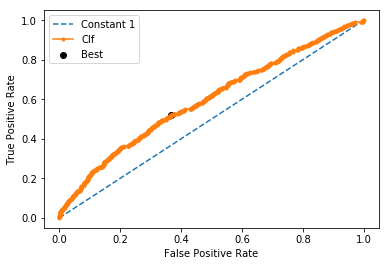

Best Threshold=0.141772, G-Mean=0.574
[[9430  298]
 [ 430   40]]
On train: [0.978329084134144, 0.4075067024128686, 1.0, 0.579047619047619, 0.9999368038601382]
On test: [0.9286134536183566, 0.11834319526627218, 0.0851063829787234, 0.09900990099009899, 0.5976783402155654]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.998


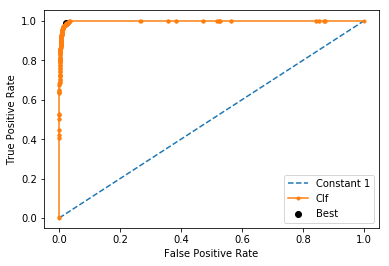

Best Threshold=0.745593, G-Mean=0.984
[[18675  1270]
 [    0   451]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.622


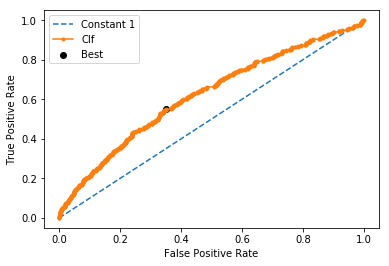

Best Threshold=0.082567, G-Mean=0.598
[[9795   80]
 [ 308   15]]
On train: [0.9377328888017258, 0.2620569436374201, 1.0, 0.4152854511970534, 0.9981635751087108]
On test: [0.961953324181212, 0.15789473684210525, 0.04643962848297214, 0.07177033492822966, 0.6215092683309166]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.994


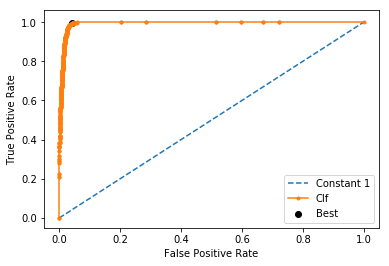

Best Threshold=0.726882, G-Mean=0.977
[[17247  2573]
 [    0   576]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.631


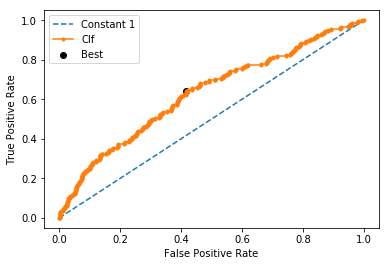

Best Threshold=0.188022, G-Mean=0.611
[[9186  814]
 [ 153   45]]
On train: [0.8738478132967249, 0.1829152111781518, 1.0, 0.30926174496644293, 0.9935914550398026]
On test: [0.9051774857815258, 0.05238649592549476, 0.22727272727272727, 0.08514664143803218, 0.6311464646464646]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.989


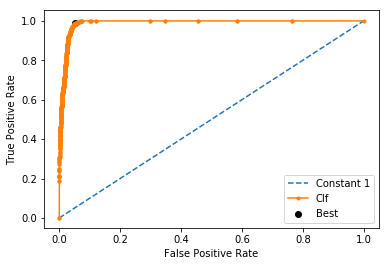

Best Threshold=0.737392, G-Mean=0.968
[[15882  3843]
 [    0   671]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.688


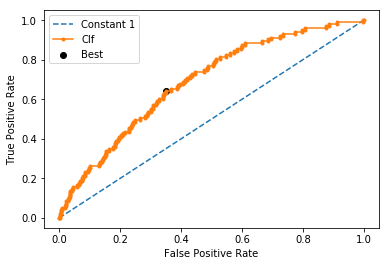

Best Threshold=0.307172, G-Mean=0.646
[[8294 1801]
 [  66   37]]
On train: [0.8115807020984507, 0.14864864864864866, 1.0, 0.25882352941176473, 0.9892294383087876]
On test: [0.8169248872327908, 0.02013057671381937, 0.3592233009708738, 0.0381246780010304, 0.687947027510495]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.995


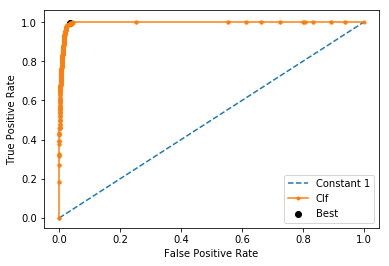

Best Threshold=0.724342, G-Mean=0.980
[[17402  2411]
 [    0   583]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.585


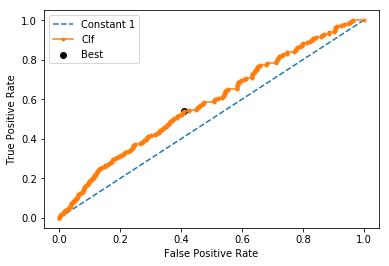

Best Threshold=0.152872, G-Mean=0.564
[[9110  897]
 [ 159   32]]
On train: [0.881790547166111, 0.19472277889111556, 1.0, 0.3259714844842046, 0.9954431568094791]
On test: [0.8964502843694843, 0.03444564047362755, 0.16753926701570682, 0.057142857142857134, 0.5849230146227484]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.994


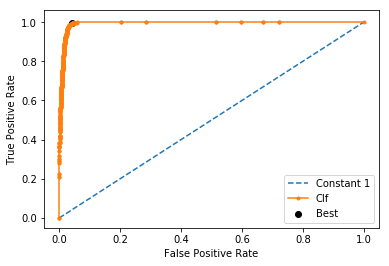

Best Threshold=0.726882, G-Mean=0.977
[[17247  2573]
 [    0   576]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.631


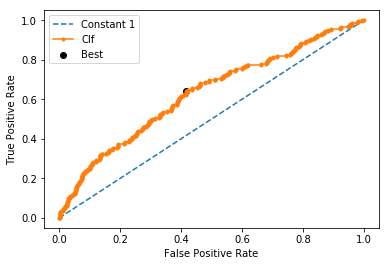

Best Threshold=0.188022, G-Mean=0.611
[[9186  814]
 [ 153   45]]
On train: [0.8738478132967249, 0.1829152111781518, 1.0, 0.30926174496644293, 0.9935914550398026]
On test: [0.9051774857815258, 0.05238649592549476, 0.22727272727272727, 0.08514664143803218, 0.6311464646464646]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.999


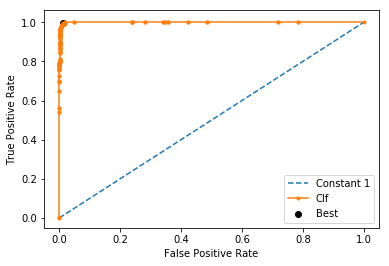

Best Threshold=0.701687, G-Mean=0.991
[[18183  1777]
 [    0   436]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.689


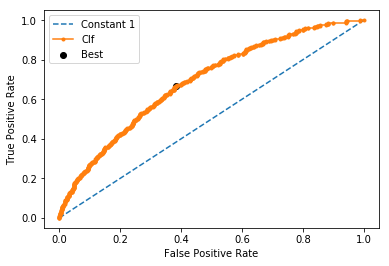

Best Threshold=0.233716, G-Mean=0.643
[[8723 1137]
 [ 242   96]]
On train: [0.9128750735438321, 0.19701762313601445, 1.0, 0.32918082295205736, 0.9993899496240186]
On test: [0.8647774073347715, 0.07785888077858881, 0.28402366863905326, 0.12221514958625079, 0.6894124248352678]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.989


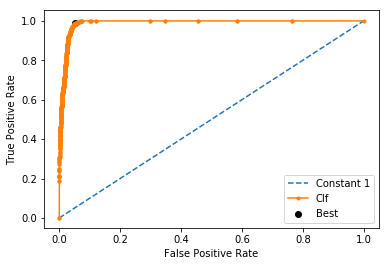

Best Threshold=0.737392, G-Mean=0.968
[[15882  3843]
 [    0   671]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.688


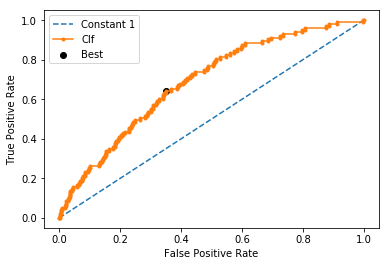

Best Threshold=0.307172, G-Mean=0.646
[[8294 1801]
 [  66   37]]
On train: [0.8115807020984507, 0.14864864864864866, 1.0, 0.25882352941176473, 0.9892294383087876]
On test: [0.8169248872327908, 0.02013057671381937, 0.3592233009708738, 0.0381246780010304, 0.687947027510495]
No Skill: ROC AUC=0.500
Clf: ROC AUC=1.000


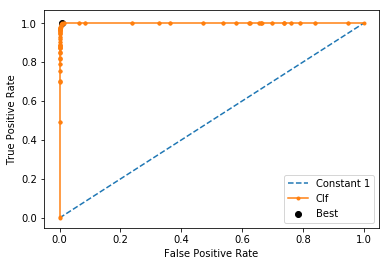

Best Threshold=0.681387, G-Mean=0.996
[[18794  1213]
 [    0   389]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.683


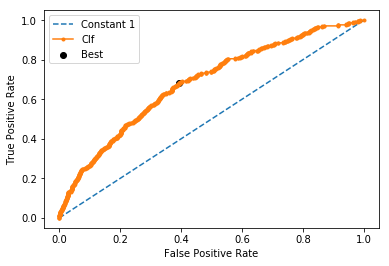

Best Threshold=0.198499, G-Mean=0.644
[[8938  875]
 [ 288   97]]
On train: [0.9405275544224357, 0.24282147315855182, 1.0, 0.3907584128578604, 0.9996980491275355]
On test: [0.885958030986468, 0.09979423868312758, 0.2519480519480519, 0.14296241709653648, 0.6833020337453232]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.990


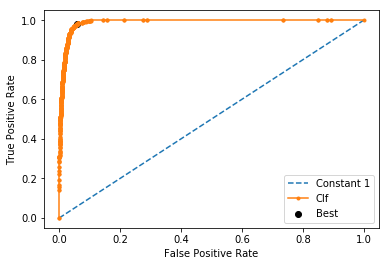

Best Threshold=0.743497, G-Mean=0.962
[[15620  4068]
 [    0   708]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.688


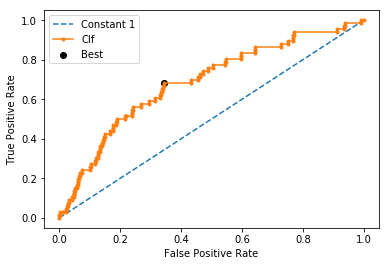

Best Threshold=0.359106, G-Mean=0.668
[[7943 2189]
 [  33   33]]
On train: [0.8005491272798588, 0.14824120603015076, 1.0, 0.25820568927789933, 0.9898945441543444]
On test: [0.7821141400274564, 0.01485148514851485, 0.5, 0.028846153846153844, 0.6883336922322314]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.995


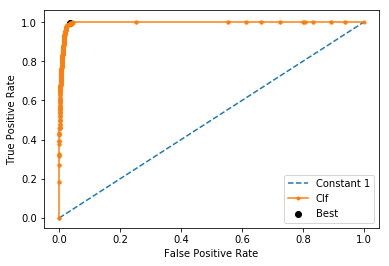

Best Threshold=0.724342, G-Mean=0.980
[[17402  2411]
 [    0   583]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.585


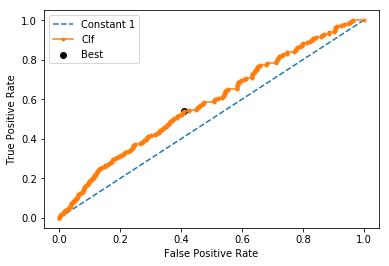

Best Threshold=0.152872, G-Mean=0.564
[[9110  897]
 [ 159   32]]
On train: [0.881790547166111, 0.19472277889111556, 1.0, 0.3259714844842046, 0.9954431568094791]
On test: [0.8964502843694843, 0.03444564047362755, 0.16753926701570682, 0.057142857142857134, 0.5849230146227484]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.999


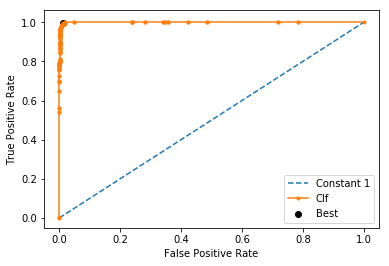

Best Threshold=0.701687, G-Mean=0.991
[[18183  1777]
 [    0   436]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.689


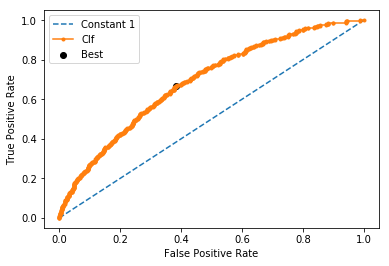

Best Threshold=0.233716, G-Mean=0.643
[[8723 1137]
 [ 242   96]]
On train: [0.9128750735438321, 0.19701762313601445, 1.0, 0.32918082295205736, 0.9993899496240186]
On test: [0.8647774073347715, 0.07785888077858881, 0.28402366863905326, 0.12221514958625079, 0.6894124248352678]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.994


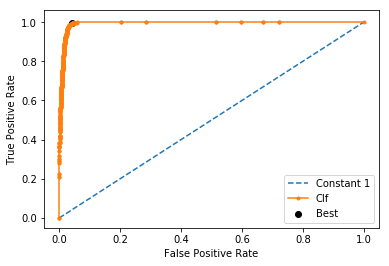

Best Threshold=0.726882, G-Mean=0.977
[[17247  2573]
 [    0   576]]
No Skill: ROC AUC=0.500
Clf: ROC AUC=0.631


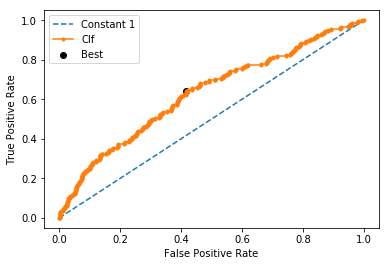

Best Threshold=0.188022, G-Mean=0.611
[[9186  814]
 [ 153   45]]
On train: [0.8738478132967249, 0.1829152111781518, 1.0, 0.30926174496644293, 0.9935914550398026]
On test: [0.9051774857815258, 0.05238649592549476, 0.22727272727272727, 0.08514664143803218, 0.6311464646464646]


In [35]:
metrics_dump = []
for i in range(20):
    clf, test_metrics = train_test_clf(clf, dataset_stations, split_ratio=0.4)
    metrics_dump.append(test_metrics)

In [46]:
names = ['acc', 'prec', 're', 'f1', 'roc_auc']
for i in range(np.array(metrics_dump).shape[-1]):
    # plt.plot(np.array(metrics_dump)[:,i], label=names[i])
    print(names[i], np.mean(np.array(metrics_dump)[:,i]), " +- ", np.std(np.array(metrics_dump)[:,i]))


acc 0.8804961757207295  +-  0.04632719320872308
prec 0.06250293456044484  +-  0.03946127372336295
re 0.24066061159780858  +-  0.11805786854868976
f1 0.08129637473415517  +-  0.03612606758616222
roc_auc 0.63986763877246  +-  0.04255338570767176


In [54]:
filename = 'model.sav'
pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
# X_train, y_train, X_test, y_test = get_split_train_test(dataset_stations, 0.4)
# clf.score(X_test, y_test)
# loaded_model.score(X_test, y_test)

False

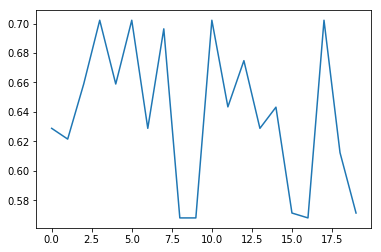

In [59]:
plt.plot(np.array(metrics_dump)[:,-1])
